* Évaluer les performances des modèles d’apprentissage non supervisé selon différents critères (scores, temps d'entraînement, etc.) en adaptant les paramètres afin de choisir le modèle le plus performant pour la problématique métier.

* CE1 Vous avez choisi des métriques adaptées pour évaluer les valeurs candidates pour le nombre de segments (selon algorithme, par exemple : coefficient silhouette / elbow pour le KMeans, eps/min samples pour le DBScan). 

* CE2 Vous avez évalué la forme des clusters. 

* CE3 Vous avez évalué la stabilité des clusters à l’initialisation. 

* CE4 Vous avez optimisé les hyper-paramètres pertinents dans les différents algorithmes. 

* CE5 Vous avez justifié le choix final d'algorithme et d'hyper-paramètres. 

* CE6 Vous avez analysé la stabilité du modèle dans le temps afin d’en assurer sa maintenance

* CE7 La convention PEP8 est respectée. Le code est commenté (commentaires réguliers, docstrings dans les fonctions) .

# Import

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from math import pi


# SKLEARN 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import davies_bouldin_score
from sklearn import cluster, metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import ParameterGrid


# Data

In [2]:
data = pd.read_csv('data_after_aed.csv')
rfm_df = pd.read_csv('rfm_df.csv')

In [3]:
data.head()

,Unnamed: 0,order_id_x,payment_sequential,payment_type,payment_installments_x,payment_value_x,customer_id,order_status,order_purchase_timestamp,order_approved_at,...,review_score_x,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,total_payment_value,average_review_score,total_number_of_orders,average_payment_installments,recency
0,0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,...,1,Não recomendo,"Produto com qualidade ruim, amassado e descasc...",2018-05-10 00:00:00,2018-05-15 23:38:00,99.33,1.0,1,8.0,-174
1,1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,f2c7fc58a9de810828715166c672f10a,delivered,2018-06-26 11:01:38,2018-06-26 11:18:58,...,5,NaN,NaN,2018-06-30 00:00:00,2018-07-03 11:23:16,24.39,5.0,1,1.0,-113
2,2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,25b14b69de0b6e184ae6fe2755e478f9,delivered,2017-12-12 11:19:55,2017-12-14 09:52:34,...,5,NaN,Aprovada,2017-12-19 00:00:00,2017-12-22 17:55:30,65.71,5.0,1,1.0,-309
3,3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,7a5d8efaaa1081f800628c30d2b0728f,delivered,2017-12-06 12:04:06,2017-12-06 12:13:20,...,5,NaN,NaN,2017-12-21 00:00:00,2017-12-21 21:42:31,215.56,5.0,2,8.0,-315
4,4,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,7a5d8efaaa1081f800628c30d2b0728f,delivered,2017-12-06 12:04:06,2017-12-06 12:13:20,...,5,NaN,NaN,2017-12-21 00:00:00,2017-12-22 01:10:39,215.56,5.0,2,8.0,-315


# Features

In [4]:
# Charge la liste depuis le fichier pickle
with open('features_list.pkl', 'rb') as file:
    features = pickle.load(file)

print(features)

['customer_state', 'payment_value', 'payment_type', 'review_score']


## Clustering avec K-means :
* Utiliser l'algorithme K-means pour regrouper les clients en fonction de leurs caractéristiques.
* Choisir un nombre approprié de clusters en utilisant des méthodes telles que la méthode du coude ou la silhouette.

In [5]:
# Méthode du coude

# RFM Data 

In [6]:
rfm_data = rfm_df[['recency', 'frequency', 'monetary', 'delivery_delay', 'average_payment_installments', 'average_review_score']]
# Standardize the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data)

In [7]:
# Convertir le tableau numpy en DataFrame
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['recency', 'frequency', 'monetary', 'delivery_delay', 'average_payment_installments', 'average_review_score'])
rfm_scaled_df['order_purchase_timestamp'] = data['order_purchase_timestamp']
rfm_scaled_df['recency_unscaled'] = data['recency']

# Enregistrer le DataFrame dans un fichier CSV
rfm_scaled_df.to_csv('data_scaled.csv', index=False)

## Calcul du nombre de clusters 

### Méthode du coude 

/Users/tarek/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tarek/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tarek/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tarek/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tarek/anacond

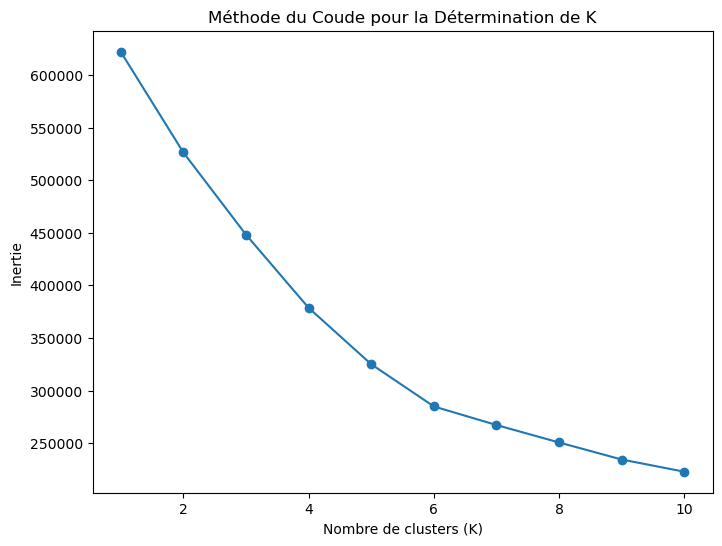

In [8]:
# Méthode du coude
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)


# Tracé du coude
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Méthode du Coude pour la Détermination de K')
plt.xlabel('Nombre de clusters (K)')
plt.ylabel('Inertie')
plt.show()

### Methode silhouette

Contraints d'utiliser un sous ensemble de données qui peut influencer 
le nombre de clusters par rapport à la méthode précedente 

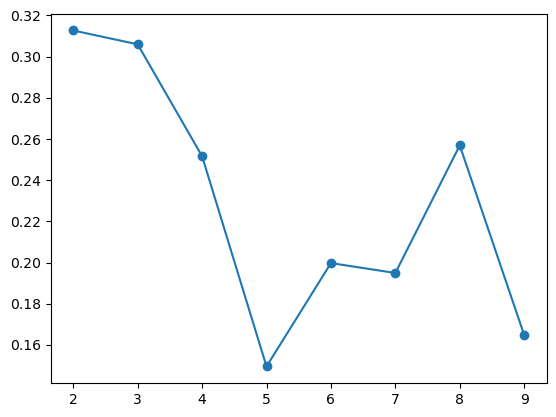

In [9]:
silhouettes = []
for num_clusters in range(2, 10):
    cls = KMeans(n_clusters=num_clusters, n_init=1, init='random')
    cls.fit(rfm_scaled[:10000])
    silh = silhouette_score(X=rfm_scaled[:10000], labels=cls.labels_)
    silhouettes.append(silh)

plt.plot(range(2, 10), silhouettes, marker='o')

### Méthode Davies Bouldin 

/Users/tarek/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tarek/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tarek/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tarek/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tarek/anacond

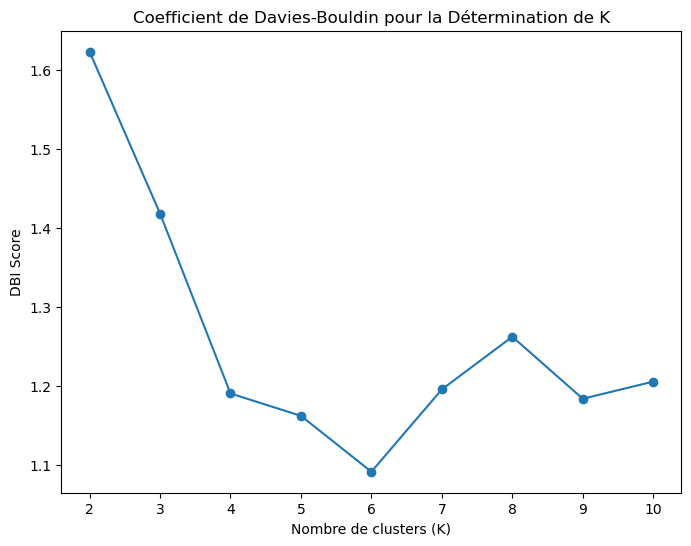

In [10]:

# Initialise une liste pour stocker les scores DBI
dbi_scores = []

# Test différentes valeurs de k
for k in range(2, 11):
    # Appliquez le KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)

    # Calculez le score DBI
    dbi = davies_bouldin_score(rfm_scaled, labels)
    dbi_scores.append(dbi)

# Tracé des scores DBI
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), dbi_scores, marker='o')
plt.title('Coefficient de Davies-Bouldin pour la Détermination de K')
plt.xlabel('Nombre de clusters (K)')
plt.ylabel('DBI Score')
plt.show()

/Users/tarek/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


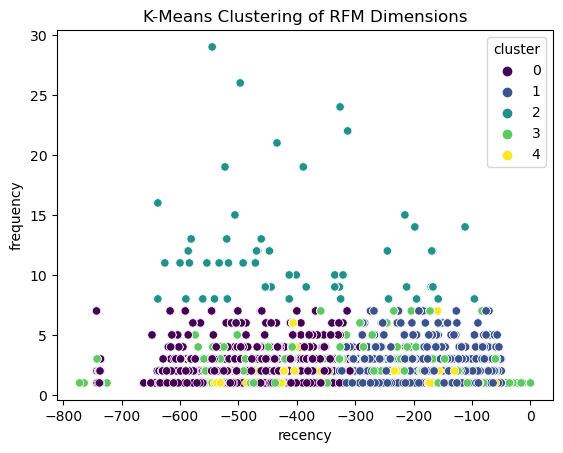

In [11]:
# Appliquer le KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
rfm_df['cluster'] = kmeans.fit_predict(rfm_scaled)

sns.scatterplot(data=rfm_df, x='recency', y='frequency', hue='cluster', palette='viridis')
plt.title('K-Means Clustering of RFM Dimensions')
plt.show()

In [12]:
rfm_df.head()

,Unnamed: 0,customer_id,frequency,monetary,recency,delivery_delay,average_payment_installments,order_purchase_timestamp,average_review_score,cluster
0,0,00012a2ce6f8dcda20d059ce98491703,1,114.74,-337,-6.0,8.0,2017-11-14 16:08:26,1.0,3
1,1,000161a058600d5901f007fab4c27140,1,67.41,-458,-10.0,5.0,2017-07-16 09:40:32,4.0,0
2,2,0001fd6190edaaf884bcaf3d49edf079,1,195.42,-596,-16.0,10.0,2017-02-28 11:06:43,5.0,4
3,3,0002414f95344307404f0ace7a26f1d5,1,179.35,-427,-1.0,1.0,2017-08-16 13:09:20,5.0,0
4,4,000379cdec625522490c315e70c7a9fb,1,107.01,-198,-5.0,1.0,2018-04-02 13:42:17,4.0,1


Text(0.5, 0.92, 'K-Means Clustering of RFM Dimensions in 3D')

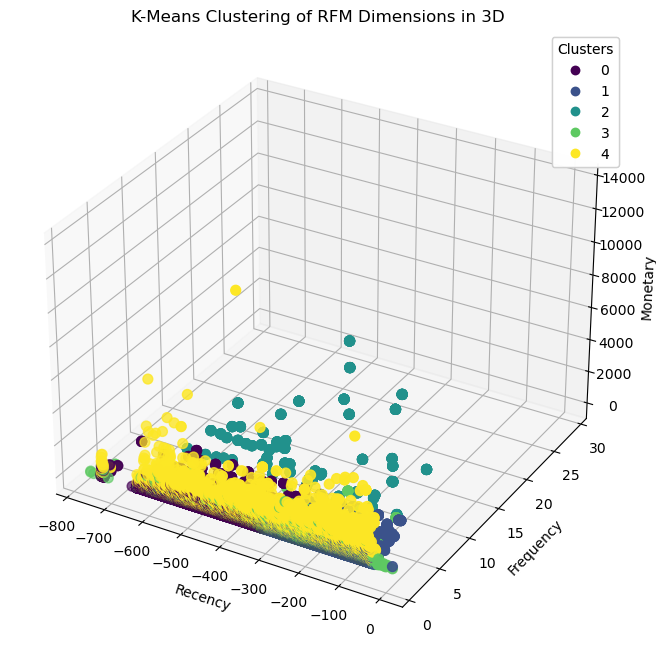

In [13]:
from mpl_toolkits.mplot3d import Axes3D

# Sélectionner les colonnes RFM et les données cluster
rfm_clustered = rfm_df[['recency', 'frequency', 'monetary', 'cluster']]

# Créer une figure en 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Tracé des points en fonction des dimensions RFM et de la couleur en fonction du cluster
scatter = ax.scatter(
    rfm_clustered['recency'],
    rfm_clustered['frequency'],
    rfm_clustered['monetary'],
    c=rfm_clustered['cluster'],
    cmap='viridis',
    s=50  # Taille des points
)

# Ajouter une légende
legend = ax.legend(*scatter.legend_elements(), title='Clusters')
ax.add_artist(legend)

# Étiquettes et titre
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('K-Means Clustering of RFM Dimensions in 3D')

## Boxplots des clusters sur les variables

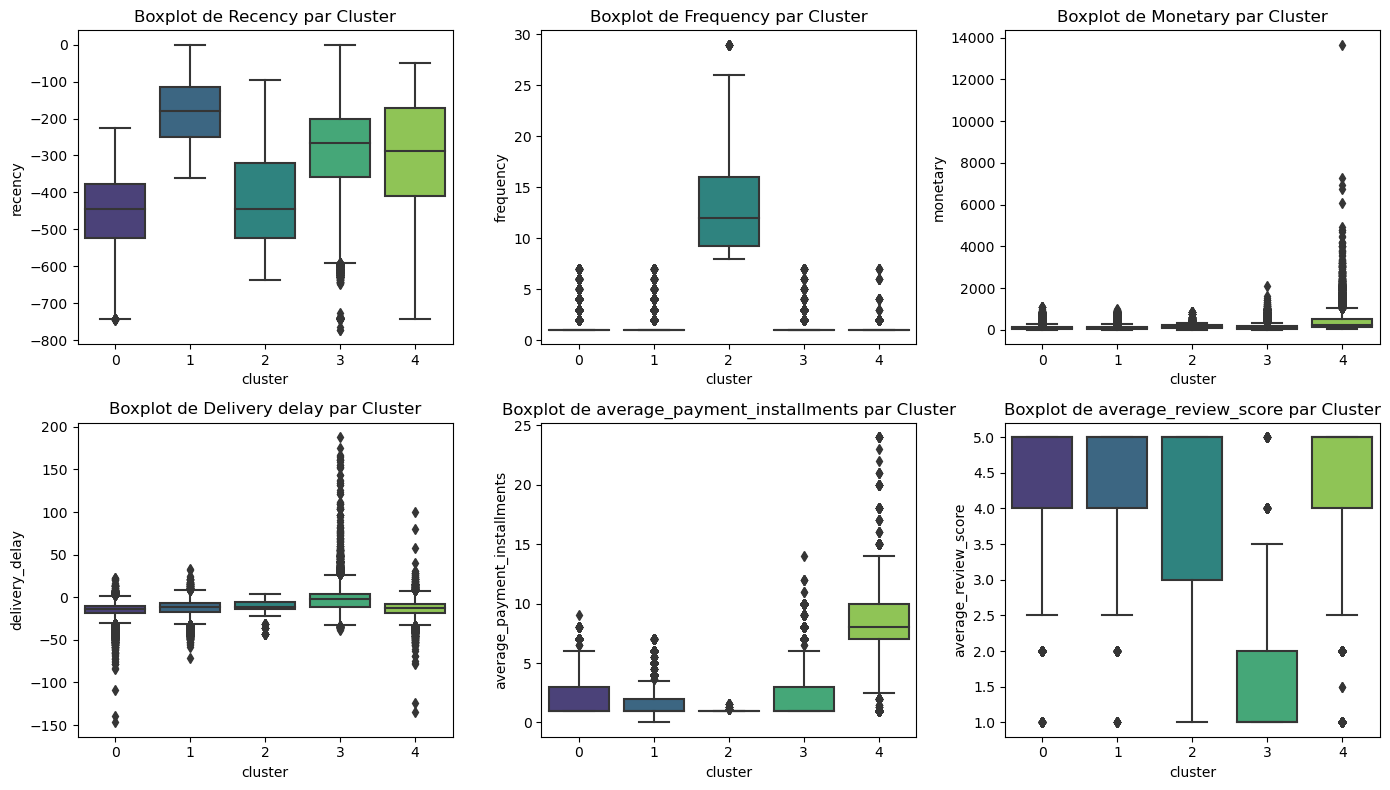

In [14]:
# Boxplots pour 'recency', 'frequency', 'monetary' en fonction de chaque cluster
plt.figure(figsize=(14, 8))

# Boxplot pour 'recency'
plt.subplot(2, 3, 1)
sns.boxplot(x='cluster', y='recency', data=rfm_df, palette='viridis')
plt.title('Boxplot de Recency par Cluster')

# Boxplot pour 'frequency'
plt.subplot(2, 3, 2)
sns.boxplot(x='cluster', y='frequency', data=rfm_df, palette='viridis')
plt.title('Boxplot de Frequency par Cluster')

# Boxplot pour 'monetary'
plt.subplot(2, 3, 3)
sns.boxplot(x='cluster', y='monetary', data=rfm_df, palette='viridis')
plt.title('Boxplot de Monetary par Cluster')

# Boxplot pour 'Delivery_delay'
plt.subplot(2, 3, 4)
sns.boxplot(x='cluster', y='delivery_delay', data=rfm_df, palette='viridis')
plt.title('Boxplot de Delivery delay par Cluster')

# Boxplot pour 'average_payment_installments'
plt.subplot(2, 3, 5)
sns.boxplot(x='cluster', y='average_payment_installments', data=rfm_df, palette='viridis')
plt.title('Boxplot de average_payment_installments par Cluster')

# Boxplot pour 'average_review_score'
plt.subplot(2, 3, 6)
sns.boxplot(x='cluster', y='average_review_score', data=rfm_df, palette='viridis')
plt.title('Boxplot de average_review_score par Cluster')

plt.tight_layout()
plt.show()


In [15]:
radar_features = ['recency', 'frequency', 'monetary', 'delivery_delay', 'average_payment_installments', 'average_review_score']
cluster_means = rfm_df.groupby('cluster')[radar_features].mean()

# Utiliser QuantileTransformer pour scaler les valeurs sur une échelle de 5
qt = QuantileTransformer(output_distribution='uniform', n_quantiles=4, random_state=42)
cluster_scaled = pd.DataFrame(qt.fit_transform(cluster_means), columns=radar_features, index=cluster_means.index)

cluster_scaled.head(5)

,recency,frequency,monetary,delivery_delay,average_payment_installments,average_review_score
cluster,,,,,,
0,0.000000,0.666999,0.010492,0.000000,0.473391,0.859927
1,1.000000,0.308568,0.000000,0.446409,0.301510,1.000000
2,0.178628,1.000000,0.687345,0.684112,0.000000,0.317970
3,0.677292,0.427716,0.463708,1.000000,0.673804,0.000000
4,0.638734,0.000000,1.000000,0.258545,1.000000,0.513825


## Visuels Radar 

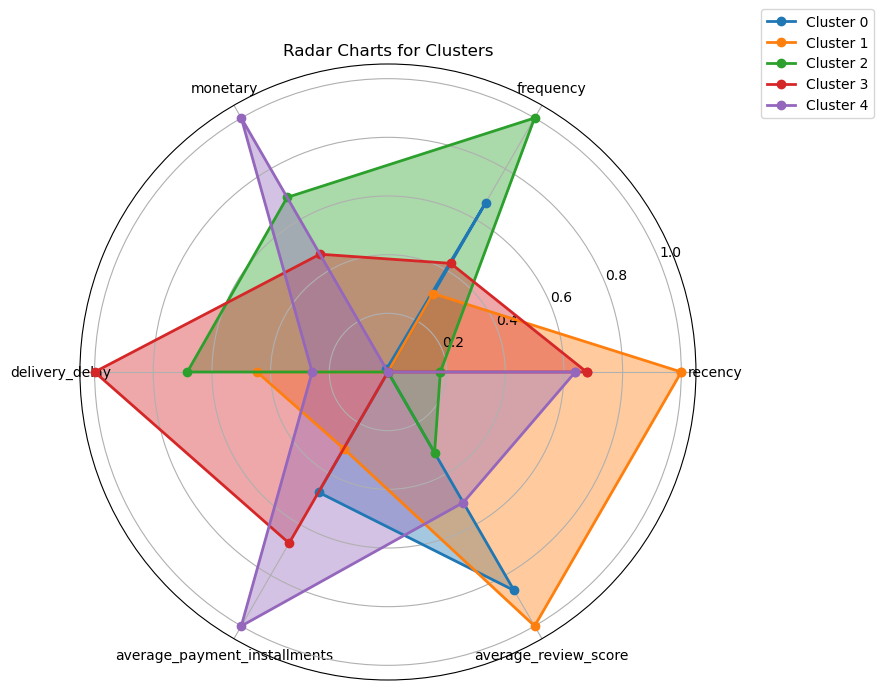

In [16]:

radar_features = ['recency', 'frequency', 'monetary', 'delivery_delay', 'average_payment_installments', 'average_review_score']

# Fonction pour créer un radar chart
def plot_radar_chart(ax, features, values, color, label):
    # Nombre d'angles
    num_features = len(features)
    angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()

    # Fermer la boucle
    values = np.concatenate([values, [values[0]]])
    angles += angles[:1]
    # Remplacer les chiffres par les noms des caractéristiques
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features)

    # Plot
    ax.plot(angles, values, color=color, marker='o', linestyle='solid', linewidth=2, label=label)
    ax.fill(angles, values, color=color, alpha=0.4)

# Liste des caractéristiques à afficher
radar_features = cluster_scaled.columns.tolist()

# Liste des couleurs
colors = plt.cm.tab10.colors

# Créer le radar chart pour chaque cluster
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(polar=True))
for i, (cluster, data) in enumerate(cluster_scaled.iterrows()):
    plot_radar_chart(ax, radar_features, data.values, colors[i], f'Cluster {cluster}')

ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title('Radar Charts for Clusters')
plt.show()

* Cluster 0 : client assez fréquent, satisfait, dépense très peu. Améliorations possibles sur le montant des commandes.
= Client à developper 

* Cluster 1 : client très récent et très satisfait. Améliorations possibles sur la fréquence / nombre de paiement par commande
= Nouveau client à fideliser

* Cluster 2 : Client très fréquent, second cluster le plus dépensier. Satisfaction faible et délais de livraison à améliorer 
= Client à risque 

* Cluster 3 : Client pas du tout satisfait, délai de livraisons très elevés. Récence assez moyenne
= Client Mécontent

* Cluster 4 : Client qui dépense le plus et qui étale le plus les paiemet. Satisfaction et récence assez moyenne .
= Meilleur client 


## Repartition des clients par cluster 

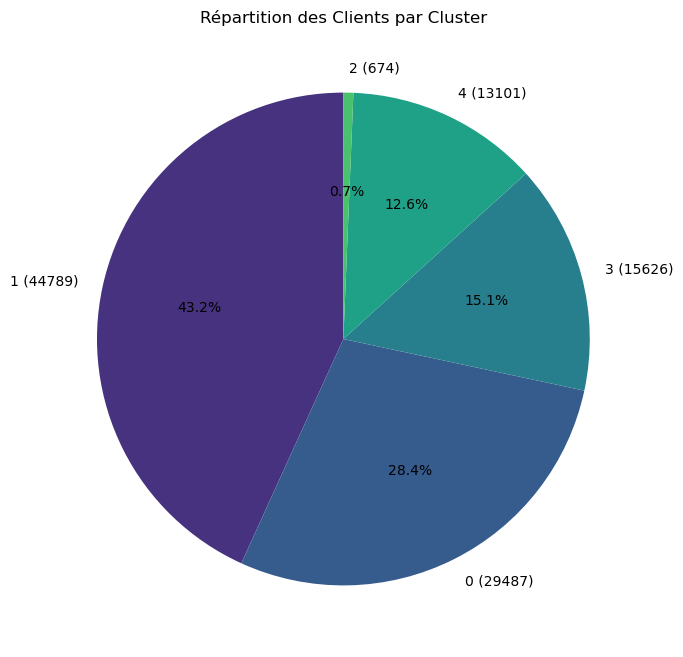

In [17]:
# Compter le nombre de clients dans chaque cluster
cluster_counts = rfm_df['cluster'].value_counts()

# Tracé du pie chart
plt.figure(figsize=(8, 8))
patches, texts, autotexts = plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis'))

# Ajouter le nombre d'individus à côté du pourcentage
for text, autotext, count in zip(texts, autotexts, cluster_counts):
    text.set_text(f'{text.get_text()} ({count})')

plt.title('Répartition des Clients par Cluster')
plt.show()

## Repartition monétaire

Total de la colonne 'monetary': 16815448.34
Contribution de chaque cluster au total (%):
cluster
0    3492279.71
1    5290192.46
2     130869.14
3    2313518.12
4    5588588.91
Name: monetary, dtype: float64


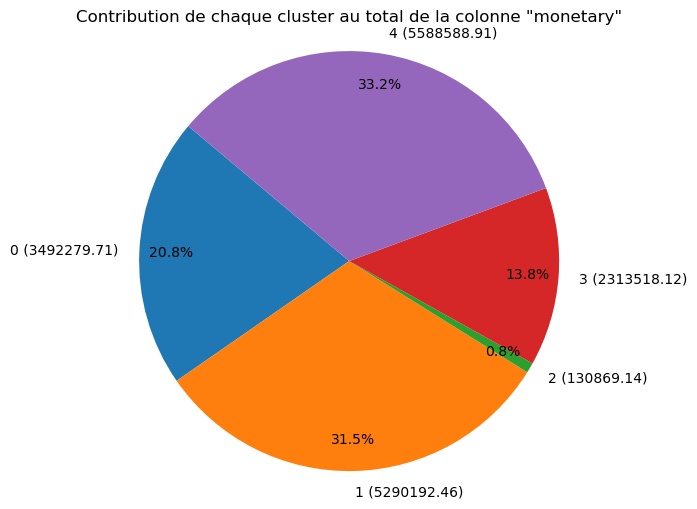

In [18]:
# Calculer le total de la colonne monetary
total_monetary = rfm_df['monetary'].sum()

# Calculer la contribution de chaque cluster au total
cluster_contributions = rfm_df.groupby('cluster')['monetary'].sum()
cluster_percentages = cluster_contributions / total_monetary * 100

# Afficher les résultats
print("Total de la colonne 'monetary':", total_monetary)
print("Contribution de chaque cluster au total (%):")
print(cluster_contributions)

# Créer un pie chart pour la contribution de chaque cluster au total
plt.figure(figsize=(8, 6))
patches, texts, autotexts = plt.pie(cluster_percentages, labels=cluster_percentages.index, autopct='%1.1f%%', startangle=140, pctdistance=0.85)
plt.title('Contribution de chaque cluster au total de la colonne "monetary"')

# Ajouter le chiffre d'affaires par cluster à côté du pourcentage
for text, autotext, contribution in zip(texts, autotexts, cluster_contributions):
    text.set_text(f'{text.get_text()} ({contribution:.2f})')

plt.axis('equal')
plt.show()


# DBSCAN (Density-Based Spatial Clustering of Applications with Noise) 

### Clusters de points par densité 

L'algorithme DBSCAN (Density-Based Spatial Clustering of Applications with Noise) a été introduit en 1996 dans ce but. Cet algorithme est très utilisé, raison pour laquelle il a obtenu en 2014 une distinction de contribution scientifique ayant résisté à l'épreuve du temps.

DBSCAN itère sur les points du jeu de données. Pour chacun des points qu'il analyse, il construit l'ensemble des points atteignables par densité depuis ce point : il calcule l'epsilon-voisinage de ce point, puis, si ce voisinage contient plus de n_min points, les epsilon-voisinages de chacun d'entre eux, et ainsi de suite, jusqu'à ne plus pouvoir agrandir le cluster. Si le point considéré n'est pas un point intérieur, c'est-à-dire qu'il n'a pas suffisamment de voisins, il sera alors étiqueté comme du bruit. Cela permet à DBSCAN d'être robuste aux données aberrantes, puisque ce mécanisme les isole.

## Hyperparamètres 

* Epsilon (eps) : distance maximal à laquel un point est considéré comme 'voisin'. Au dessus de ce distance, les autres points sont ignorés (du bruit). Si la valeure est faible on peut obtenir de nombreux petits clusters et si valeur trop importante on obtient en conséquence des clusters catégorisés en bruit.

* min_samples : le nombre minimal de points dans le voisinage pour qu'un point est consideré un point 'central' du cluster (ne change pas de cluster)

## Vérifier sample / data complète

In [20]:
rfm_scaled_df.head()

,recency,frequency,monetary,delivery_delay,average_payment_installments,average_review_score,order_purchase_timestamp,recency_unscaled
0,-0.295098,-0.162078,-0.213394,0.549432,1.926477,-2.289431,2018-04-25 22:01:49,-174
1,-1.080760,-0.162078,-0.426245,0.156067,0.803366,-0.062275,2018-06-26 11:01:38,-113
2,-1.976804,-0.162078,0.149438,-0.433980,2.675217,0.680110,2017-12-12 11:19:55,-309
3,-0.879474,-0.162078,0.077168,1.041138,-0.694114,0.680110,2017-12-06 12:04:06,-315
4,0.607440,-0.162078,-0.248157,0.647773,-0.694114,-0.062275,2017-12-06 12:04:06,-315


In [21]:
data_comparison = rfm_scaled_df[['recency', 'frequency', 'monetary', 'delivery_delay', 'average_payment_installments', 'average_review_score']]

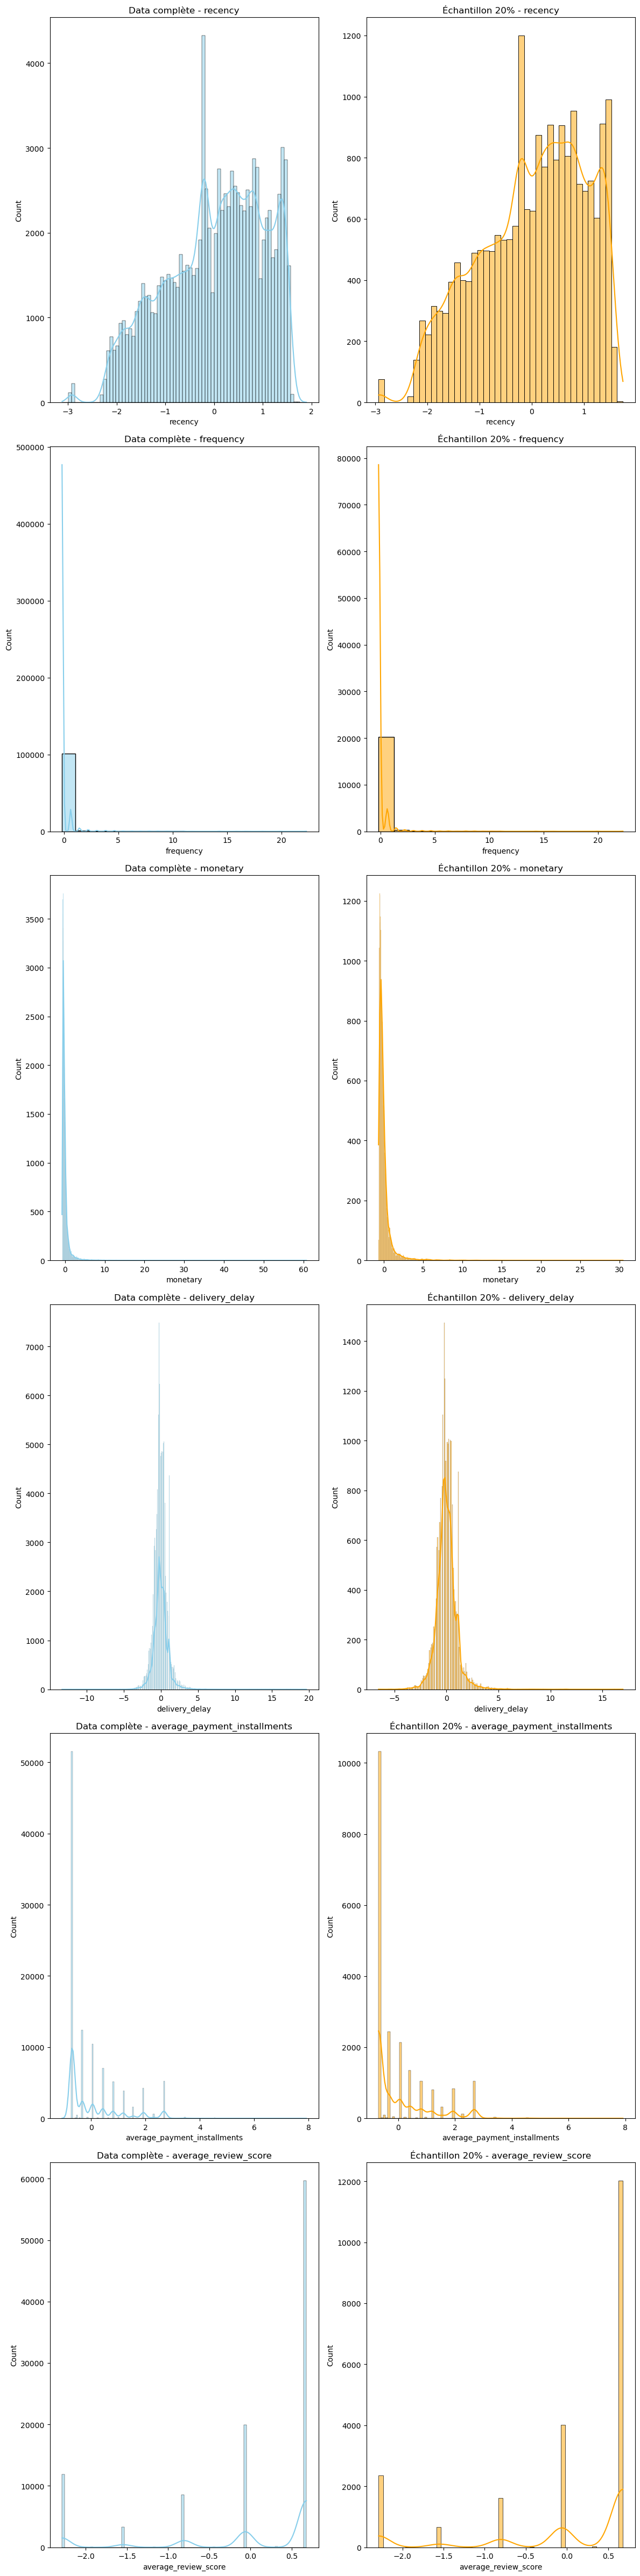

In [31]:
# Sélectionner un échantillon de 20% de la data
sample_data = data_comparison.sample(frac=0.2, random_state=42)

# Définir les variables à comparer
variables_to_compare = ['recency', 'frequency', 'monetary', 'delivery_delay', 'average_payment_installments', 'average_review_score']

# Créer une figure avec des sous-tracés pour chaque variable
fig, axes = plt.subplots(nrows=len(variables_to_compare), ncols=2, figsize=(12, 8 * len(variables_to_compare)))

# Boucle sur chaque variable
for i, variable in enumerate(variables_to_compare):
    # Tracé de la distribution pour la data complète
    sns.histplot(data_comparison[variable], kde=True, ax=axes[i, 0], color='skyblue')
    axes[i, 0].set_title(f'Data complète - {variable}')
    
    # Tracé de la distribution pour un échantillon de 20%
    sns.histplot(sample_data[variable], kde=True, ax=axes[i, 1], color='orange')
    axes[i, 1].set_title(f'Échantillon 20% - {variable}')

# Ajustements de la disposition
plt.tight_layout()
plt.show()

On peut donc partir sur le sample qui est cohérent avec la data complète. 
Important :  ne convient qu'en l'état avec les features selectionnées.

In [32]:
sample_data.head()

,recency,frequency,monetary,delivery_delay,average_payment_installments,average_review_score
78521,0.191883,-0.162078,0.189282,0.647773,1.926477,-0.062275
88276,-0.509369,-0.162078,3.390096,-0.138956,0.428996,0.680110
82210,0.997024,-0.162078,-0.356584,-1.122368,-0.319744,-0.062275
24095,-0.762599,-0.162078,-0.158214,0.156067,1.926477,0.680110
60597,-1.911873,-0.162078,-0.573617,0.057726,0.054626,0.680110


In [34]:
# Définir les paramètres à rechercher
param_grid = {
    'eps': [1, 2, 3],
    'min_samples': [5, 10, 20]
}

# Générer toutes les combinaisons possibles des paramètres
param_combinations = list(ParameterGrid(param_grid))

# Sélectionner les colonnes à utiliser
features = ['recency', 'frequency', 'monetary', 'delivery_delay', 'average_payment_installments', 'average_review_score']
X = sample_data[features]

best_score = -1
best_params = None

# Recherche des meilleurs paramètres
for params in param_combinations:
    dbscan = DBSCAN(**params)
    labels = dbscan.fit_predict(X)
    
    # Ignorer les clusters avec -1 (outliers)
    if len(set(labels)) > 1:
        score = silhouette_score(X, labels)
        
        # Mettre à jour les meilleurs paramètres si le score est meilleur
        if score > best_score:
            best_score = score
            best_params = params

print("Meilleurs paramètres :", best_params)
print("Score silhouette correspondant :", best_score)

Meilleurs paramètres : {'eps': 3, 'min_samples': 10}
Score silhouette correspondant : 0.8182194717295147


In [38]:
#Appliquer DBSCAN avec les paramètres déterminés
dbscan = DBSCAN(eps=2, min_samples=200)
labels = dbscan.fit_predict(X)

#Afficher les résultats
print("Étiquettes DBSCAN:")
print(np.unique(labels))
print("Compte de chaque étiquette DBSCAN:")
print(np.bincount(labels + 1)[1:])

#Exclure le cluster de bruit (-1) lors du comptage des clusters
unique_labels = set(labels) - {-1}

#Nombre total de clusters (en excluant le bruit)
num_clusters = len(unique_labels)

print(f"Nombre de clusters estimé : {num_clusters}")

Étiquettes DBSCAN:
[-1  0]
Compte de chaque étiquette DBSCAN:
[20296]
Nombre de clusters estimé : 1
